In [1]:
# draw boxplot for each cohort and cluster
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd

# Configure matplotlib for better PDF text handling
mpl.rcParams['pdf.fonttype'] = 42  # TrueType fonts instead of Type 3 fonts
mpl.rcParams['axes.unicode_minus'] = False  # Ensures minus signs render properly

def select_clusters(diff_df, data_dir):
    selected_diff = diff_df.loc[os.listdir(data_dir), ]
    num_df = (selected_diff < 0.05).sum(axis=0)
    clusters = num_df[num_df>2].index.tolist()
    return clusters
    


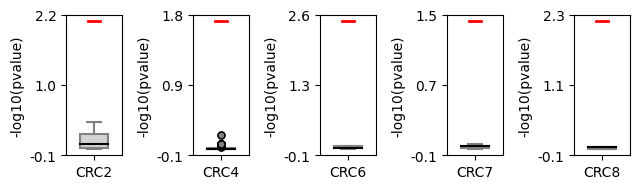

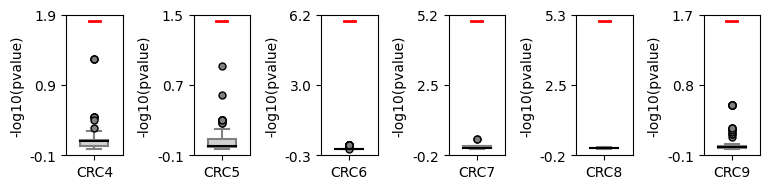

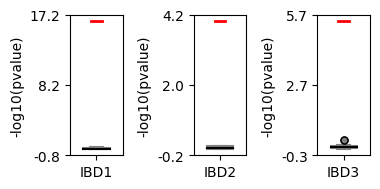

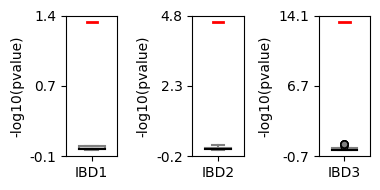

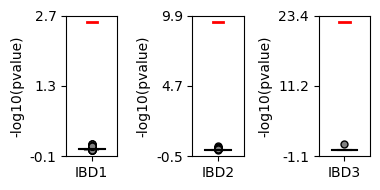

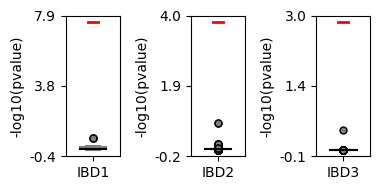

In [2]:
outer_dir = '../data'
indir = '../result/large_scale_cohort'
output_dir = '../result/validation/phenotype_shuffle'
diff_df = pd.read_csv(os.path.join(indir, 'p_all_cohorts_se.tsv'), sep='\t', header=0, index_col=0)
plist = ['CRC', 'IBD']
for pheno in plist:
    data_dir = os.path.join(outer_dir, pheno)
    clusters = select_clusters(diff_df, data_dir)
    for cluster in clusters:
        cohort_simus = []
        cohort_reals = []
        labels = []
        max_y = 0
        tmp_idir = os.path.join(indir, pheno)
        for cohort in os.listdir(data_dir):
            if not os.path.isdir(os.path.join(tmp_idir, cohort)):
                continue
            real_path = os.path.join(tmp_idir, cohort, 'SE', 'p_detail.tsv')
            real_pvalues = pd.read_csv(real_path, sep='\t', header=0, index_col=0)
            if pd.isna(real_pvalues.loc[cluster, 'p_adj']):
                continue
            if real_pvalues.loc[cluster, 'p_adj'] > 0.05:
                continue
            labels.append(cohort)
            outdir = os.path.join(output_dir, pheno, cohort)
            simu_pvalues = pd.read_csv(os.path.join(outdir, 'pvalues.tsv'), sep='\t', header=None, index_col=0)
        # result\GCN_fix_tree\SE\GCN_tree_diff\CRC\CRC1\p_CRC1.tsv
            
            simu_v = [-np.log10(x) for x in list(simu_pvalues.loc[cluster, :])]
            real_v = -np.log10(real_pvalues.loc[cluster, 'p_adj'])
            cohort_simus.append(simu_v)
            cohort_reals.append(real_v)
    
        fig, axes = plt.subplots(1, len(cohort_reals), figsize=(len(cohort_reals)*1.3,2))
        # Create boxplots
        for i, value in enumerate(cohort_reals):
            # Create boxplot
            bp = axes[i].boxplot(cohort_simus[i], patch_artist=True, widths=0.5)
            
            # Set boxplot colors to gray
            for box in bp['boxes']:
                box.set(color='gray', linewidth=1.5)
                box.set(facecolor='lightgray')
            for whisker in bp['whiskers']:
                whisker.set(color='gray', linewidth=1.5)
            for cap in bp['caps']:
                cap.set(color='gray', linewidth=1.5)
            for median in bp['medians']:
                median.set(color='black', linewidth=1.5)
            for flier in bp['fliers']:
                flier.set(marker='o', markerfacecolor='gray', markersize=5)
            
            # Add reference line in red
            axes[i].axhline(y=cohort_reals[i], xmin=0.4, xmax=0.6, color='red', linestyle='-', linewidth=2)

            # set x-axis labels
            axes[i].set_xticklabels([labels[i]])

            # Get current y-axis limits
            ymin, ymax = axes[i].get_ylim()
            
            # Set y-ticks to only show min and max values
            axes[i].set_yticks([ymin, (ymin+ymax)/2 ,ymax])
            axes[i].set_yticklabels([f'{ymin:.1f}', f'{(ymin+ymax)/2:.1f}',  f'{ymax:.1f}'])
            axes[i].set_ylabel('-log10(pvalue)')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, pheno, '{}.svg'.format(cluster)), dpi=300)
        plt.show()
        #plt.savefig(os.path.join(output_dir, pheno, '{}.svg'.format(cluster)), dpi=300, format='svg')
         